In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math
import re
from re import findall

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm

import io
import os
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
print('baseline profit & loss per day:', baseline_pnl)
df_trainval

baseline profit & loss per day: 0.0366


,dist_low_28,dist_low_60,dist_low_30,in_sess_time,dist_high_60,dist_high_30,dist_high_28,minute_time,hour_time,ret_std_z_90,...,roc_28,ret,eng_ma,roc_60,vwap_dev_pct_z_90,close_raw,signal,pred_signal,ask,bid
2009-01-02 12:30:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.147157,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,1.624044e-07,0.057928,3.070257,3.069029
2009-01-02 12:31:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.148829,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,1.840283e-07,0.057924,3.070257,3.069029
2009-01-02 12:32:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.150502,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.085314e-07,0.057702,3.070257,3.069029
2009-01-02 12:33:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.152174,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.362970e-07,0.057463,3.070257,3.069029
2009-01-02 12:34:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.153846,0.1,0.500000,...,0.504537,0.500548,0.502857,0.503281,0.500000,3.069643,2.677596e-07,0.057207,3.070257,3.069029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 20:56:00,0.190111,0.131679,0.183189,1.0,0.057014,0.044131,0.045622,0.993311,0.9,0.497293,...,0.574868,0.381398,0.598511,0.517734,0.506818,131.730000,1.177684e-01,0.076478,131.756346,131.703654
2022-12-23 20:57:00,0.218606,0.151416,0.210647,1.0,0.037104,0.016540,0.017098,0.994983,0.9,0.497872,...,0.586577,0.575084,0.604313,0.525328,0.515176,131.805000,5.830165e-02,0.102399,131.831361,131.778639
2022-12-23 20:58:00,0.228097,0.157990,0.219793,1.0,0.030473,0.007350,0.007598,0.996655,0.9,0.498126,...,0.588698,0.525379,0.609390,0.526069,0.515504,131.830000,3.644749e-02,0.107804,131.856366,131.803634
2022-12-23 20:59:00,0.239482,0.165876,0.230763,1.0,0.022518,0.000000,0.000000,0.998328,0.9,0.499176,...,0.586543,0.530340,0.619565,0.524711,0.513793,131.860000,0.000000e+00,0.122011,131.886372,131.833628


In [4]:
# Pre-compute per-day slices once
groups = df_trainval.groupby(df_trainval.index.normalize())
prun_perc = 70
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    
    sign_smoothwin = trial.suggest_categorical("sign_smoothwin", [3, 5, 10, 20, 30, 45, 60, 90, 120, 180])
    sellmin_idx    = trial.suggest_categorical("sellmin_idx", [None, -1, -2, -3])
    sess_start     = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat(), params.sess_start_reg.isoformat()]))
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.03, 0.9)

    print('-----------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Simulate trading using parameters ==> sign_smoothwin:',sign_smoothwin,'sellmin_idx:',sellmin_idx,'sess_start:','trailstop_pct:',round(trailstop_pct,4))
    
    daily_pnls: List[float] = []
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        # Causal smoothing of the raw pred_signal
        df_day["predsig_smooth"] = (
            df_day["pred_signal"]
              .rolling(window=sign_smoothwin, min_periods=1)
              .mean()
        )

        # Generate actions on the smoothed column
        df_actions = trades.generate_trade_actions(
            df                = df_day,
            col_signal        = "pred_signal",
            col_price         = "close_raw",
            buy_thresh        = df_day["predsig_smooth"],
            trailstop_pct     = trailstop_pct,
            sellmin_idx       = sellmin_idx,
            sess_start        = sess_start
            )

        # Simulate 1-day P&L
        sim = trades.simulate_trading(
            day               = day,
            df                = df_actions,
            sellmin_idx       = sellmin_idx, 
            sess_start        = sess_start
        )
   
        _, _, stats = next(iter(sim.values()))
        
        strategy_val = float(_findall(stats["STRATEGY"])[-1]) 

        daily_pnls.append(strategy_val)

        # Explicitly delete large locals at the end of each trial (no per-iteration gc.collect)
        del df_actions, sim, stats
        df_day = df_actions = sim = stats = None

        # Rreport for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.1261


Trial 0: 100%|██████████| 3520/3520 [00:34<00:00, 101.48it/s]


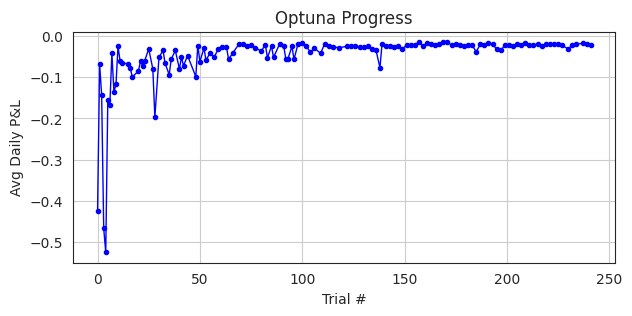

[Results] Trial 0 finished with value: -0.4253. Improvement over baseline: -1262.15%.     Best is trial 0 with value: -0.4253.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.738


Trial 1: 100%|██████████| 3520/3520 [00:36<00:00, 97.46it/s] 


[Results] Trial 1 finished with value: -0.0683. Improvement over baseline: -286.67%.     Best is trial 1 with value: -0.0683.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -1 sess_start: trailstop_pct: 0.7228


Trial 2: 100%|██████████| 3520/3520 [00:39<00:00, 88.18it/s] 


[Results] Trial 2 finished with value: -0.1428. Improvement over baseline: -490.14%.     Best is trial 1 with value: -0.0683.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -1 sess_start: trailstop_pct: 0.2121


Trial 3: 100%|██████████| 3520/3520 [00:48<00:00, 72.95it/s] 


[Results] Trial 3 finished with value: -0.4669. Improvement over baseline: -1375.65%.     Best is trial 1 with value: -0.0683.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -1 sess_start: trailstop_pct: 0.1812


Trial 4: 100%|██████████| 3520/3520 [00:59<00:00, 59.03it/s]


[Results] Trial 4 finished with value: -0.5251. Improvement over baseline: -1534.71%.     Best is trial 1 with value: -0.0683.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -3 sess_start: trailstop_pct: 0.5447


Trial 5: 100%|██████████| 3520/3520 [00:49<00:00, 70.42it/s] 


[Results] Trial 5 finished with value: -0.1563. Improvement over baseline: -526.93%.     Best is trial 1 with value: -0.0683.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: -2 sess_start: trailstop_pct: 0.5303


Trial 6: 100%|██████████| 3520/3520 [00:49<00:00, 70.84it/s]


[Results] Trial 6 finished with value: -0.1677. Improvement over baseline: -558.20%.     Best is trial 1 with value: -0.0683.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.8055


Trial 7: 100%|██████████| 3520/3520 [00:50<00:00, 69.14it/s]


[Results] Trial 7 finished with value: -0.0414. Improvement over baseline: -213.11%.     Best is trial 7 with value: -0.0414.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -3 sess_start: trailstop_pct: 0.7646


Trial 8: 100%|██████████| 3520/3520 [00:47<00:00, 73.91it/s]


[Results] Trial 8 finished with value: -0.1353. Improvement over baseline: -469.56%.     Best is trial 7 with value: -0.0414.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -3 sess_start: trailstop_pct: 0.5899


Trial 9: 100%|██████████| 3520/3520 [00:49<00:00, 70.54it/s]


[Results] Trial 9 finished with value: -0.1172. Improvement over baseline: -420.31%.     Best is trial 7 with value: -0.0414.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8823


Trial 10: 100%|██████████| 3520/3520 [00:43<00:00, 80.94it/s] 


[Results] Trial 10 finished with value: -0.0246. Improvement over baseline: -167.27%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8764


Trial 11: 100%|██████████| 3520/3520 [00:43<00:00, 81.71it/s] 


[Results] Trial 11 finished with value: -0.0602. Improvement over baseline: -264.45%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.8939


Trial 12: 100%|██████████| 3520/3520 [00:49<00:00, 71.83it/s] 


[Results] Trial 12 finished with value: -0.0643. Improvement over baseline: -275.64%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.4058


Trial 13:  26%|██▌       | 899/3520 [00:12<00:37, 69.93it/s]


[PRUNE] value=-0.213488 thr=-0.067587
[Results] Trial 13 finished with value: -0.2135. Improvement over baseline: -683.30%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -2 sess_start: trailstop_pct: 0.3869


Trial 14:  52%|█████▏    | 1847/3520 [00:28<00:25, 64.92it/s]


[PRUNE] value=-0.149375 thr=-0.088346
[Results] Trial 14 finished with value: -0.1494. Improvement over baseline: -508.13%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.642


Trial 15: 100%|██████████| 3520/3520 [00:55<00:00, 63.81it/s]


[Results] Trial 15 finished with value: -0.0678. Improvement over baseline: -285.34%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.8129


Trial 16: 100%|██████████| 3520/3520 [00:53<00:00, 66.37it/s] 


[Results] Trial 16 finished with value: -0.0784. Improvement over baseline: -314.18%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.6868


Trial 17: 100%|██████████| 3520/3520 [00:46<00:00, 75.99it/s]


[Results] Trial 17 finished with value: -0.0993. Improvement over baseline: -371.44%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -2 sess_start: trailstop_pct: 0.8257


Trial 18:  25%|██▌       | 892/3520 [00:13<00:39, 65.85it/s]


[PRUNE] value=-0.182076 thr=-0.067459
[Results] Trial 18 finished with value: -0.1821. Improvement over baseline: -597.47%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.3216


Trial 19:  55%|█████▌    | 1944/3520 [00:30<00:24, 63.40it/s]


[PRUNE] value=-0.153602 thr=-0.083185
[Results] Trial 19 finished with value: -0.1536. Improvement over baseline: -519.68%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.6384


Trial 20: 100%|██████████| 3520/3520 [00:50<00:00, 70.04it/s]


[Results] Trial 20 finished with value: -0.0843. Improvement over baseline: -330.43%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8944


Trial 21: 100%|██████████| 3520/3520 [00:50<00:00, 70.14it/s]


[Results] Trial 21 finished with value: -0.0599. Improvement over baseline: -263.75%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8157


Trial 22: 100%|██████████| 3520/3520 [00:42<00:00, 83.29it/s] 


[Results] Trial 22 finished with value: -0.0716. Improvement over baseline: -295.71%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8664


Trial 23: 100%|██████████| 3520/3520 [00:44<00:00, 79.21it/s] 


[Results] Trial 23 finished with value: -0.0602. Improvement over baseline: -264.58%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.7768


Trial 24:  26%|██▌       | 898/3520 [00:13<00:39, 66.86it/s]


[PRUNE] value=-0.159577 thr=-0.067714
[Results] Trial 24 finished with value: -0.1596. Improvement over baseline: -536.00%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8881


Trial 25: 100%|██████████| 3520/3520 [00:55<00:00, 62.86it/s]


[Results] Trial 25 finished with value: -0.0310. Improvement over baseline: -184.75%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -1 sess_start: trailstop_pct: 0.6843


Trial 26:  25%|██▌       | 893/3520 [00:13<00:39, 67.30it/s]


[PRUNE] value=-0.192740 thr=-0.066822
[Results] Trial 26 finished with value: -0.1927. Improvement over baseline: -626.61%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -2 sess_start: trailstop_pct: 0.8105


Trial 27: 100%|██████████| 3520/3520 [00:53<00:00, 65.33it/s]


[Results] Trial 27 finished with value: -0.0792. Improvement over baseline: -316.53%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -3 sess_start: trailstop_pct: 0.4813


Trial 28: 100%|██████████| 3520/3520 [00:49<00:00, 71.63it/s] 


[Results] Trial 28 finished with value: -0.1971. Improvement over baseline: -638.44%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.0339


Trial 29:  25%|██▌       | 893/3520 [00:15<00:45, 57.43it/s]


[PRUNE] value=-0.269056 thr=-0.062180
[Results] Trial 29 finished with value: -0.2691. Improvement over baseline: -835.12%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.7209


Trial 30: 100%|██████████| 3520/3520 [00:59<00:00, 58.82it/s]


[Results] Trial 30 finished with value: -0.0517. Improvement over baseline: -241.15%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.7644


Trial 31:  25%|██▌       | 894/3520 [00:14<00:42, 61.73it/s]


[PRUNE] value=-0.158986 thr=-0.055149
[Results] Trial 31 finished with value: -0.1590. Improvement over baseline: -534.39%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.845


Trial 32: 100%|██████████| 3520/3520 [00:36<00:00, 96.35it/s] 


[Results] Trial 32 finished with value: -0.0345. Improvement over baseline: -194.26%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8436


Trial 33: 100%|██████████| 3520/3520 [00:43<00:00, 81.49it/s] 


[Results] Trial 33 finished with value: -0.0660. Improvement over baseline: -280.42%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.7426


Trial 34:  25%|██▌       | 894/3520 [00:13<00:40, 65.09it/s]


[PRUNE] value=-0.154281 thr=-0.054877
[Results] Trial 34 finished with value: -0.1543. Improvement over baseline: -521.53%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: -1 sess_start: trailstop_pct: 0.8937


Trial 35: 100%|██████████| 3520/3520 [00:50<00:00, 70.32it/s]


[Results] Trial 35 finished with value: -0.0934. Improvement over baseline: -355.23%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.6931


Trial 36: 100%|██████████| 3520/3520 [00:52<00:00, 67.45it/s]


[Results] Trial 36 finished with value: -0.0558. Improvement over baseline: -252.54%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -1 sess_start: trailstop_pct: 0.8053


Trial 37:  25%|██▌       | 895/3520 [00:12<00:35, 73.86it/s]


[PRUNE] value=-0.177067 thr=-0.051411
[Results] Trial 37 finished with value: -0.1771. Improvement over baseline: -583.79%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.8432


Trial 38: 100%|██████████| 3520/3520 [00:50<00:00, 69.48it/s]


[Results] Trial 38 finished with value: -0.0348. Improvement over baseline: -194.99%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -3 sess_start: trailstop_pct: 0.6374


Trial 39:  25%|██▌       | 897/3520 [00:13<00:39, 66.07it/s]


[PRUNE] value=-0.199580 thr=-0.043537
[Results] Trial 39 finished with value: -0.1996. Improvement over baseline: -645.30%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -2 sess_start: trailstop_pct: 0.8446


Trial 40: 100%|██████████| 3520/3520 [00:46<00:00, 76.34it/s]


[Results] Trial 40 finished with value: -0.0797. Improvement over baseline: -317.65%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.7649


Trial 41: 100%|██████████| 3520/3520 [00:45<00:00, 77.37it/s] 


[Results] Trial 41 finished with value: -0.0515. Improvement over baseline: -240.74%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.8526


Trial 42: 100%|██████████| 3520/3520 [00:37<00:00, 93.72it/s] 


[Results] Trial 42 finished with value: -0.0715. Improvement over baseline: -295.48%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.8998


Trial 43:  27%|██▋       | 942/3520 [00:09<00:26, 96.00it/s] 


[PRUNE] value=-0.144519 thr=-0.036044
[Results] Trial 43 finished with value: -0.1445. Improvement over baseline: -494.86%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.7743


Trial 44: 100%|██████████| 3520/3520 [00:38<00:00, 91.04it/s] 


[Results] Trial 44 finished with value: -0.0474. Improvement over baseline: -229.52%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.572


Trial 45:  25%|██▌       | 892/3520 [00:10<00:29, 89.17it/s]


[PRUNE] value=-0.182333 thr=-0.035774
[Results] Trial 45 finished with value: -0.1823. Improvement over baseline: -598.18%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: -3 sess_start: trailstop_pct: 0.722


Trial 46:  82%|████████▏ | 2894/3520 [00:29<00:06, 97.61it/s] 


[PRUNE] value=-0.067037 thr=-0.032288
[Results] Trial 46 finished with value: -0.0670. Improvement over baseline: -283.16%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.2399


Trial 47:  38%|███▊      | 1343/3520 [00:14<00:23, 91.35it/s] 


[PRUNE] value=-0.145596 thr=-0.040928
[Results] Trial 47 finished with value: -0.1456. Improvement over baseline: -497.80%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -1 sess_start: trailstop_pct: 0.7983


Trial 48: 100%|██████████| 3520/3520 [00:33<00:00, 105.71it/s]


[Results] Trial 48 finished with value: -0.0982. Improvement over baseline: -368.41%.     Best is trial 10 with value: -0.0246.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8693


Trial 49: 100%|██████████| 3520/3520 [00:36<00:00, 96.79it/s] 


[Results] Trial 49 finished with value: -0.0228. Improvement over baseline: -162.34%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8558


Trial 50: 100%|██████████| 3520/3520 [00:36<00:00, 97.10it/s] 


[Results] Trial 50 finished with value: -0.0620. Improvement over baseline: -269.46%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8439


Trial 51:  26%|██▌       | 898/3520 [00:09<00:27, 95.93it/s] 


[PRUNE] value=-0.151772 thr=-0.035523
[Results] Trial 51 finished with value: -0.1518. Improvement over baseline: -514.68%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8601


Trial 52: 100%|██████████| 3520/3520 [00:45<00:00, 77.78it/s]


[Results] Trial 52 finished with value: -0.0287. Improvement over baseline: -178.54%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8707


Trial 53: 100%|██████████| 3520/3520 [00:56<00:00, 62.65it/s]


[Results] Trial 53 finished with value: -0.0589. Improvement over baseline: -260.90%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8272


Trial 54:  25%|██▌       | 896/3520 [00:14<00:42, 61.25it/s]


[PRUNE] value=-0.152286 thr=-0.034518
[Results] Trial 54 finished with value: -0.1523. Improvement over baseline: -516.08%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.791


Trial 55: 100%|██████████| 3520/3520 [00:51<00:00, 68.64it/s] 


[Results] Trial 55 finished with value: -0.0399. Improvement over baseline: -209.00%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -2 sess_start: trailstop_pct: 0.8999


Trial 56:  25%|██▌       | 897/3520 [00:08<00:26, 99.81it/s] 


[PRUNE] value=-0.179351 thr=-0.033078
[Results] Trial 56 finished with value: -0.1794. Improvement over baseline: -590.03%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.7356


Trial 57: 100%|██████████| 3520/3520 [00:57<00:00, 61.57it/s]


[Results] Trial 57 finished with value: -0.0505. Improvement over baseline: -238.08%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.8675


Trial 58:  25%|██▌       | 896/3520 [00:14<00:41, 63.22it/s]


[PRUNE] value=-0.153251 thr=-0.031413
[Results] Trial 58 finished with value: -0.1533. Improvement over baseline: -518.72%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8231


Trial 59: 100%|██████████| 3520/3520 [00:46<00:00, 75.85it/s] 


[Results] Trial 59 finished with value: -0.0312. Improvement over baseline: -185.38%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -3 sess_start: trailstop_pct: 0.6582


Trial 60:  25%|██▌       | 893/3520 [00:10<00:29, 89.00it/s] 


[PRUNE] value=-0.190997 thr=-0.029377
[Results] Trial 60 finished with value: -0.1910. Improvement over baseline: -621.85%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8205


Trial 61: 100%|██████████| 3520/3520 [00:52<00:00, 67.61it/s]


[Results] Trial 61 finished with value: -0.0269. Improvement over baseline: -173.39%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8245


Trial 62:  27%|██▋       | 948/3520 [00:14<00:39, 64.60it/s]


[PRUNE] value=-0.142500 thr=-0.026735
[Results] Trial 62 finished with value: -0.1425. Improvement over baseline: -489.34%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.873


Trial 63: 100%|██████████| 3520/3520 [00:39<00:00, 88.73it/s] 


[Results] Trial 63 finished with value: -0.0251. Improvement over baseline: -168.50%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8783


Trial 64: 100%|██████████| 3520/3520 [00:38<00:00, 92.28it/s] 


[Results] Trial 64 finished with value: -0.0565. Improvement over baseline: -254.27%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.7893


Trial 65:  25%|██▌       | 894/3520 [00:10<00:30, 85.43it/s]


[PRUNE] value=-0.153738 thr=-0.028729
[Results] Trial 65 finished with value: -0.1537. Improvement over baseline: -520.05%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.7497


Trial 66: 100%|██████████| 3520/3520 [00:50<00:00, 70.17it/s]


[Results] Trial 66 finished with value: -0.0413. Improvement over baseline: -212.94%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8193


Trial 67:  25%|██▌       | 897/3520 [00:13<00:40, 65.04it/s]


[PRUNE] value=-0.151154 thr=-0.028878
[Results] Trial 67 finished with value: -0.1512. Improvement over baseline: -512.99%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: -2 sess_start: trailstop_pct: 0.4066


Trial 68:  42%|████▏     | 1494/3520 [00:22<00:30, 65.55it/s]


[PRUNE] value=-0.106313 thr=-0.027046
[Results] Trial 68 finished with value: -0.1063. Improvement over baseline: -390.47%.     Best is trial 49 with value: -0.0228.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8738


Trial 69: 100%|██████████| 3520/3520 [00:49<00:00, 71.29it/s] 


[Results] Trial 69 finished with value: -0.0199. Improvement over baseline: -154.43%.     Best is trial 69 with value: -0.0199.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -1 sess_start: trailstop_pct: 0.8765


Trial 70:  25%|██▌       | 897/3520 [00:09<00:26, 97.56it/s] 


[PRUNE] value=-0.174477 thr=-0.028633
[Results] Trial 70 finished with value: -0.1745. Improvement over baseline: -576.71%.     Best is trial 69 with value: -0.0199.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8773


Trial 71: 100%|██████████| 3520/3520 [00:38<00:00, 92.21it/s] 


[Results] Trial 71 finished with value: -0.0185. Improvement over baseline: -150.68%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8649


Trial 72:  25%|██▌       | 897/3520 [00:10<00:31, 84.50it/s]


[PRUNE] value=-0.150598 thr=-0.028228
[Results] Trial 72 finished with value: -0.1506. Improvement over baseline: -511.47%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8862


Trial 73: 100%|██████████| 3520/3520 [00:37<00:00, 94.82it/s] 


[Results] Trial 73 finished with value: -0.0249. Improvement over baseline: -168.09%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.7919


Trial 74:  25%|██▌       | 896/3520 [00:09<00:28, 93.37it/s] 


[PRUNE] value=-0.153270 thr=-0.027227
[Results] Trial 74 finished with value: -0.1533. Improvement over baseline: -518.77%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8735


Trial 75: 100%|██████████| 3520/3520 [00:42<00:00, 82.35it/s] 


[Results] Trial 75 finished with value: -0.0211. Improvement over baseline: -157.57%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.885


Trial 76:  25%|██▌       | 892/3520 [00:12<00:36, 71.10it/s]


[PRUNE] value=-0.151412 thr=-0.027028
[Results] Trial 76 finished with value: -0.1514. Improvement over baseline: -513.69%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.834


Trial 77: 100%|██████████| 3520/3520 [00:48<00:00, 71.93it/s]


[Results] Trial 77 finished with value: -0.0275. Improvement over baseline: -175.10%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.5115


Trial 78:  25%|██▌       | 891/3520 [00:13<00:38, 67.77it/s]


[PRUNE] value=-0.182371 thr=-0.027056
[Results] Trial 78 finished with value: -0.1824. Improvement over baseline: -598.28%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -3 sess_start: trailstop_pct: 0.8013


Trial 79:  82%|████████▏ | 2898/3520 [00:39<00:08, 73.48it/s]


[PRUNE] value=-0.057658 thr=-0.016423
[Results] Trial 79 finished with value: -0.0577. Improvement over baseline: -257.54%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.7545


Trial 80: 100%|██████████| 3520/3520 [00:49<00:00, 71.37it/s]


[Results] Trial 80 finished with value: -0.0367. Improvement over baseline: -200.29%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8314


Trial 81:  25%|██▌       | 895/3520 [00:12<00:37, 69.62it/s]


[PRUNE] value=-0.150706 thr=-0.026991
[Results] Trial 81 finished with value: -0.1507. Improvement over baseline: -511.76%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8999


Trial 82: 100%|██████████| 3520/3520 [00:49<00:00, 71.10it/s]


[Results] Trial 82 finished with value: -0.0204. Improvement over baseline: -155.70%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8956


Trial 83: 100%|██████████| 3520/3520 [00:50<00:00, 69.59it/s]


[Results] Trial 83 finished with value: -0.0523. Improvement over baseline: -242.90%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8734


Trial 84:  25%|██▌       | 897/3520 [00:12<00:37, 69.03it/s]


[PRUNE] value=-0.149937 thr=-0.026772
[Results] Trial 84 finished with value: -0.1499. Improvement over baseline: -509.66%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8995


Trial 85: 100%|██████████| 3520/3520 [00:50<00:00, 69.73it/s]


[Results] Trial 85 finished with value: -0.0243. Improvement over baseline: -166.51%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8996


Trial 86: 100%|██████████| 3520/3520 [00:49<00:00, 71.53it/s]


[Results] Trial 86 finished with value: -0.0513. Improvement over baseline: -240.18%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -1 sess_start: trailstop_pct: 0.8551


Trial 87:  25%|██▌       | 894/3520 [00:12<00:35, 73.96it/s]


[PRUNE] value=-0.176481 thr=-0.026552
[Results] Trial 87 finished with value: -0.1765. Improvement over baseline: -582.19%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: -2 sess_start: trailstop_pct: 0.0879


Trial 88:  25%|██▌       | 895/3520 [00:16<00:47, 55.67it/s]


[PRUNE] value=-0.594286 thr=-0.026552
[Results] Trial 88 finished with value: -0.5943. Improvement over baseline: -1723.73%.     Best is trial 71 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8769


Trial 89: 100%|██████████| 3520/3520 [00:48<00:00, 73.15it/s]


[Results] Trial 89 finished with value: -0.0185. Improvement over baseline: -150.67%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.2613


Trial 90:  25%|██▌       | 891/3520 [00:13<00:39, 67.19it/s]


[PRUNE] value=-0.237268 thr=-0.026205
[Results] Trial 90 finished with value: -0.2373. Improvement over baseline: -748.27%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8733


Trial 91: 100%|██████████| 3520/3520 [00:41<00:00, 83.92it/s]


[Results] Trial 91 finished with value: -0.0242. Improvement over baseline: -166.22%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8466


Trial 92: 100%|██████████| 3520/3520 [00:43<00:00, 81.18it/s]


[Results] Trial 92 finished with value: -0.0561. Improvement over baseline: -253.24%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8537


Trial 93: 100%|██████████| 3520/3520 [00:40<00:00, 86.54it/s]


[Results] Trial 93 finished with value: -0.0553. Improvement over baseline: -251.04%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.7777


Trial 94:  25%|██▌       | 892/3520 [00:10<00:31, 83.90it/s]


[PRUNE] value=-0.151950 thr=-0.026158
[Results] Trial 94 finished with value: -0.1519. Improvement over baseline: -515.16%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8832


Trial 95: 100%|██████████| 3520/3520 [00:40<00:00, 86.31it/s]


[Results] Trial 95 finished with value: -0.0247. Improvement over baseline: -167.53%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8807


Trial 96: 100%|██████████| 3520/3520 [00:40<00:00, 86.97it/s]


[Results] Trial 96 finished with value: -0.0563. Improvement over baseline: -253.69%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8079


Trial 97:  27%|██▋       | 949/3520 [00:10<00:29, 86.81it/s]


[PRUNE] value=-0.140764 thr=-0.023892
[Results] Trial 97 finished with value: -0.1408. Improvement over baseline: -484.60%.     Best is trial 89 with value: -0.0185.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8578


Trial 98: 100%|██████████| 3520/3520 [00:42<00:00, 83.60it/s]


[Results] Trial 98 finished with value: -0.0179. Improvement over baseline: -148.94%.     Best is trial 98 with value: -0.0179.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -3 sess_start: trailstop_pct: 0.8362


Trial 99:  25%|██▌       | 896/3520 [00:10<00:29, 87.65it/s]


[PRUNE] value=-0.175369 thr=-0.025525
[Results] Trial 99 finished with value: -0.1754. Improvement over baseline: -579.15%.     Best is trial 98 with value: -0.0179.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8598


Trial 100: 100%|██████████| 3520/3520 [00:41<00:00, 83.86it/s]


[Results] Trial 100 finished with value: -0.0166. Improvement over baseline: -145.35%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8589


Trial 101:  26%|██▌       | 898/3520 [00:10<00:31, 82.28it/s]


[PRUNE] value=-0.149457 thr=-0.025269
[Results] Trial 101 finished with value: -0.1495. Improvement over baseline: -508.35%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8385


Trial 102: 100%|██████████| 3520/3520 [00:40<00:00, 86.85it/s]


[Results] Trial 102 finished with value: -0.0247. Improvement over baseline: -167.61%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8667


Trial 103:  25%|██▌       | 895/3520 [00:10<00:31, 83.06it/s]


[PRUNE] value=-0.149159 thr=-0.025319
[Results] Trial 103 finished with value: -0.1492. Improvement over baseline: -507.54%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.8185


Trial 104: 100%|██████████| 3520/3520 [00:41<00:00, 85.21it/s]


[Results] Trial 104 finished with value: -0.0384. Improvement over baseline: -205.05%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.7792


Trial 105:  25%|██▌       | 895/3520 [00:11<00:33, 77.83it/s]


[PRUNE] value=-0.156306 thr=-0.025203
[Results] Trial 105 finished with value: -0.1563. Improvement over baseline: -527.06%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.8565


Trial 106: 100%|██████████| 3520/3520 [00:42<00:00, 82.85it/s]


[Results] Trial 106 finished with value: -0.0289. Improvement over baseline: -179.09%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8977


Trial 107:  25%|██▌       | 895/3520 [00:11<00:32, 81.22it/s]


[PRUNE] value=-0.148348 thr=-0.025253
[Results] Trial 107 finished with value: -0.1483. Improvement over baseline: -505.32%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -1 sess_start: trailstop_pct: 0.8796


Trial 108:  93%|█████████▎| 3290/3520 [00:37<00:02, 88.48it/s]


[PRUNE] value=-0.072002 thr=-0.008043
[Results] Trial 108 finished with value: -0.0720. Improvement over baseline: -296.73%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.8086


Trial 109: 100%|██████████| 3520/3520 [00:41<00:00, 84.04it/s]


[Results] Trial 109 finished with value: -0.0419. Improvement over baseline: -214.59%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -2 sess_start: trailstop_pct: 0.8615


Trial 110:  25%|██▌       | 895/3520 [00:10<00:29, 87.77it/s]


[PRUNE] value=-0.176186 thr=-0.025161
[Results] Trial 110 finished with value: -0.1762. Improvement over baseline: -581.38%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8781


Trial 111: 100%|██████████| 3520/3520 [00:41<00:00, 84.50it/s]


[Results] Trial 111 finished with value: -0.0179. Improvement over baseline: -148.96%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.835


Trial 112:  25%|██▌       | 896/3520 [00:10<00:30, 85.73it/s]


[PRUNE] value=-0.146606 thr=-0.025131
[Results] Trial 112 finished with value: -0.1466. Improvement over baseline: -500.56%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8839


Trial 113: 100%|██████████| 3520/3520 [00:43<00:00, 81.61it/s]


[Results] Trial 113 finished with value: -0.0247. Improvement over baseline: -167.62%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8988


Trial 114:  25%|██▌       | 891/3520 [00:11<00:32, 79.93it/s]


[PRUNE] value=-0.147752 thr=-0.024939
[Results] Trial 114 finished with value: -0.1478. Improvement over baseline: -503.69%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8458


Trial 115: 100%|██████████| 3520/3520 [00:41<00:00, 84.23it/s]


[Results] Trial 115 finished with value: -0.0260. Improvement over baseline: -170.94%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8661


Trial 116:  25%|██▌       | 897/3520 [00:11<00:32, 81.32it/s]


[PRUNE] value=-0.150358 thr=-0.024304
[Results] Trial 116 finished with value: -0.1504. Improvement over baseline: -510.81%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.4426


Trial 117:  78%|███████▊  | 2747/3520 [00:33<00:09, 82.47it/s]


[PRUNE] value=-0.064936 thr=-0.016551
[Results] Trial 117 finished with value: -0.0649. Improvement over baseline: -277.42%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.7983


Trial 118: 100%|██████████| 3520/3520 [00:40<00:00, 85.89it/s]


[Results] Trial 118 finished with value: -0.0280. Improvement over baseline: -176.49%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.3348


Trial 119:  26%|██▌       | 899/3520 [00:11<00:32, 81.45it/s]


[PRUNE] value=-0.227558 thr=-0.023114
[Results] Trial 119 finished with value: -0.2276. Improvement over baseline: -721.74%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.594


Trial 120:  86%|████████▋ | 3044/3520 [00:38<00:06, 79.04it/s]


[PRUNE] value=-0.056103 thr=-0.007310
[Results] Trial 120 finished with value: -0.0561. Improvement over baseline: -253.29%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8798


Trial 121:  25%|██▌       | 891/3520 [00:10<00:32, 81.86it/s]


[PRUNE] value=-0.149344 thr=-0.023114
[Results] Trial 121 finished with value: -0.1493. Improvement over baseline: -508.04%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8849


Trial 122: 100%|██████████| 3520/3520 [00:45<00:00, 78.18it/s]


[Results] Trial 122 finished with value: -0.0246. Improvement over baseline: -167.22%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8262


Trial 123:  25%|██▌       | 894/3520 [00:11<00:33, 78.02it/s]


[PRUNE] value=-0.147080 thr=-0.022556
[Results] Trial 123 finished with value: -0.1471. Improvement over baseline: -501.86%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8654


Trial 124: 100%|██████████| 3520/3520 [00:41<00:00, 83.93it/s]


[Results] Trial 124 finished with value: -0.0232. Improvement over baseline: -163.38%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8485


Trial 125:  25%|██▌       | 895/3520 [00:10<00:31, 82.04it/s]


[PRUNE] value=-0.146043 thr=-0.022601
[Results] Trial 125 finished with value: -0.1460. Improvement over baseline: -499.03%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8701


Trial 126: 100%|██████████| 3520/3520 [00:45<00:00, 77.61it/s]


[Results] Trial 126 finished with value: -0.0238. Improvement over baseline: -165.08%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: -3 sess_start: trailstop_pct: 0.8677


Trial 127:  25%|██▌       | 897/3520 [00:10<00:31, 82.90it/s]


[PRUNE] value=-0.174858 thr=-0.022490
[Results] Trial 127 finished with value: -0.1749. Improvement over baseline: -577.75%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8157


Trial 128: 100%|██████████| 3520/3520 [00:48<00:00, 72.42it/s]


[Results] Trial 128 finished with value: -0.0265. Improvement over baseline: -172.45%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.8978


Trial 129:  25%|██▌       | 897/3520 [00:12<00:37, 69.92it/s]


[PRUNE] value=-0.148931 thr=-0.022355
[Results] Trial 129 finished with value: -0.1489. Improvement over baseline: -506.92%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8426


Trial 130: 100%|██████████| 3520/3520 [00:48<00:00, 72.15it/s]


[Results] Trial 130 finished with value: -0.0255. Improvement over baseline: -169.72%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8732


Trial 131:  25%|██▌       | 894/3520 [00:13<00:38, 68.43it/s]


[PRUNE] value=-0.145433 thr=-0.022413
[Results] Trial 131 finished with value: -0.1454. Improvement over baseline: -497.36%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.854


Trial 132: 100%|██████████| 3520/3520 [00:49<00:00, 71.80it/s]


[Results] Trial 132 finished with value: -0.0239. Improvement over baseline: -165.35%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8532


Trial 133:  25%|██▌       | 893/3520 [00:11<00:34, 77.08it/s]


[PRUNE] value=-0.146016 thr=-0.022470
[Results] Trial 133 finished with value: -0.1460. Improvement over baseline: -498.95%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8271


Trial 134: 100%|██████████| 3520/3520 [00:44<00:00, 79.48it/s]


[Results] Trial 134 finished with value: -0.0305. Improvement over baseline: -183.21%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8657


Trial 135:  26%|██▌       | 899/3520 [00:11<00:33, 78.87it/s]


[PRUNE] value=-0.145964 thr=-0.022537
[Results] Trial 135 finished with value: -0.1460. Improvement over baseline: -498.81%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.8382


Trial 136: 100%|██████████| 3520/3520 [00:41<00:00, 84.39it/s] 


[Results] Trial 136 finished with value: -0.0329. Improvement over baseline: -189.93%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: -1 sess_start: trailstop_pct: 0.8843


Trial 137:  25%|██▌       | 894/3520 [00:12<00:37, 69.25it/s]


[PRUNE] value=-0.176056 thr=-0.022621
[Results] Trial 137 finished with value: -0.1761. Improvement over baseline: -581.03%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: -2 sess_start: trailstop_pct: 0.8981


Trial 138: 100%|██████████| 3520/3520 [00:48<00:00, 72.16it/s]


[Results] Trial 138 finished with value: -0.0767. Improvement over baseline: -309.52%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8558


Trial 139: 100%|██████████| 3520/3520 [00:50<00:00, 69.51it/s]


[Results] Trial 139 finished with value: -0.0191. Improvement over baseline: -152.23%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.7955


Trial 140:  26%|██▌       | 899/3520 [00:12<00:37, 69.44it/s]


[PRUNE] value=-0.149781 thr=-0.022509
[Results] Trial 140 finished with value: -0.1498. Improvement over baseline: -509.24%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8669


Trial 141: 100%|██████████| 3520/3520 [00:48<00:00, 72.37it/s]


[Results] Trial 141 finished with value: -0.0238. Improvement over baseline: -165.06%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.862


Trial 142:  26%|██▌       | 899/3520 [00:12<00:37, 70.04it/s]


[PRUNE] value=-0.146254 thr=-0.022584
[Results] Trial 142 finished with value: -0.1463. Improvement over baseline: -499.60%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8511


Trial 143: 100%|██████████| 3520/3520 [00:43<00:00, 80.94it/s]


[Results] Trial 143 finished with value: -0.0246. Improvement over baseline: -167.09%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8162


Trial 144:  25%|██▌       | 896/3520 [00:10<00:31, 83.00it/s]


[PRUNE] value=-0.147849 thr=-0.022659
[Results] Trial 144 finished with value: -0.1478. Improvement over baseline: -503.96%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8356


Trial 145: 100%|██████████| 3520/3520 [00:43<00:00, 81.86it/s]


[Results] Trial 145 finished with value: -0.0264. Improvement over baseline: -172.06%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 120 sellmin_idx: None sess_start: trailstop_pct: 0.8739


Trial 146:  25%|██▌       | 891/3520 [00:11<00:32, 80.03it/s]


[PRUNE] value=-0.145476 thr=-0.022734
[Results] Trial 146 finished with value: -0.1455. Improvement over baseline: -497.47%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8557


Trial 147: 100%|██████████| 3520/3520 [00:43<00:00, 80.31it/s]


[Results] Trial 147 finished with value: -0.0235. Improvement over baseline: -164.24%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.851


Trial 148:  25%|██▌       | 893/3520 [00:10<00:31, 82.88it/s]


[PRUNE] value=-0.149544 thr=-0.022765
[Results] Trial 148 finished with value: -0.1495. Improvement over baseline: -508.59%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8072


Trial 149: 100%|██████████| 3520/3520 [00:43<00:00, 81.37it/s]


[Results] Trial 149 finished with value: -0.0313. Improvement over baseline: -185.43%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8294


Trial 150:  25%|██▌       | 893/3520 [00:10<00:32, 81.40it/s]


[PRUNE] value=-0.150262 thr=-0.022774
[Results] Trial 150 finished with value: -0.1503. Improvement over baseline: -510.55%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8732


Trial 151: 100%|██████████| 3520/3520 [00:43<00:00, 81.44it/s]


[Results] Trial 151 finished with value: -0.0209. Improvement over baseline: -157.21%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8584


Trial 152:  25%|██▌       | 892/3520 [00:11<00:33, 79.45it/s]


[PRUNE] value=-0.149413 thr=-0.022784
[Results] Trial 152 finished with value: -0.1494. Improvement over baseline: -508.23%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8824


Trial 153: 100%|██████████| 3520/3520 [00:43<00:00, 80.83it/s]


[Results] Trial 153 finished with value: -0.0223. Improvement over baseline: -161.02%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8826


Trial 154:  25%|██▌       | 892/3520 [00:11<00:33, 78.18it/s]


[PRUNE] value=-0.148459 thr=-0.022806
[Results] Trial 154 finished with value: -0.1485. Improvement over baseline: -505.63%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8786


Trial 155: 100%|██████████| 3520/3520 [00:43<00:00, 80.51it/s]


[Results] Trial 155 finished with value: -0.0208. Improvement over baseline: -156.71%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -3 sess_start: trailstop_pct: 0.8872


Trial 156:  26%|██▌       | 899/3520 [00:10<00:31, 82.81it/s]


[PRUNE] value=-0.176370 thr=-0.022854
[Results] Trial 156 finished with value: -0.1764. Improvement over baseline: -581.89%.     Best is trial 100 with value: -0.0166.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8997


Trial 157: 100%|██████████| 3520/3520 [00:42<00:00, 82.00it/s]


[Results] Trial 157 finished with value: -0.0147. Improvement over baseline: -140.30%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8974


Trial 158:  25%|██▌       | 893/3520 [00:11<00:33, 77.77it/s]


[PRUNE] value=-0.147743 thr=-0.022781
[Results] Trial 158 finished with value: -0.1477. Improvement over baseline: -503.67%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8403


Trial 159: 100%|██████████| 3520/3520 [00:44<00:00, 79.39it/s]


[Results] Trial 159 finished with value: -0.0246. Improvement over baseline: -167.32%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.1443


Trial 160:  25%|██▌       | 892/3520 [00:12<00:36, 71.73it/s]


[PRUNE] value=-0.324201 thr=-0.022790
[Results] Trial 160 finished with value: -0.3242. Improvement over baseline: -985.80%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8736


Trial 161: 100%|██████████| 3520/3520 [00:42<00:00, 82.50it/s]


[Results] Trial 161 finished with value: -0.0160. Improvement over baseline: -143.76%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8794


Trial 162:  25%|██▌       | 895/3520 [00:11<00:33, 78.65it/s]


[PRUNE] value=-0.148266 thr=-0.022768
[Results] Trial 162 finished with value: -0.1483. Improvement over baseline: -505.10%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8992


Trial 163: 100%|██████████| 3520/3520 [00:43<00:00, 81.07it/s]


[Results] Trial 163 finished with value: -0.0196. Improvement over baseline: -153.61%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8998


Trial 164:  25%|██▌       | 895/3520 [00:11<00:34, 75.04it/s]


[PRUNE] value=-0.147879 thr=-0.022778
[Results] Trial 164 finished with value: -0.1479. Improvement over baseline: -504.04%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.88


Trial 165: 100%|██████████| 3520/3520 [00:43<00:00, 80.52it/s]


[Results] Trial 165 finished with value: -0.0223. Improvement over baseline: -160.88%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8853


Trial 166:  25%|██▌       | 897/3520 [00:11<00:33, 79.30it/s]


[PRUNE] value=-0.148427 thr=-0.022787
[Results] Trial 166 finished with value: -0.1484. Improvement over baseline: -505.54%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8996


Trial 167: 100%|██████████| 3520/3520 [00:43<00:00, 80.54it/s]


[Results] Trial 167 finished with value: -0.0198. Improvement over baseline: -154.19%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -1 sess_start: trailstop_pct: 0.8839


Trial 168:  25%|██▌       | 893/3520 [00:10<00:32, 81.68it/s]


[PRUNE] value=-0.176239 thr=-0.022822
[Results] Trial 168 finished with value: -0.1762. Improvement over baseline: -581.53%.     Best is trial 157 with value: -0.0147.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8959


Trial 169: 100%|██████████| 3520/3520 [00:44<00:00, 78.29it/s]


[Results] Trial 169 finished with value: -0.0146. Improvement over baseline: -140.02%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -2 sess_start: trailstop_pct: 0.8995


Trial 170:  25%|██▌       | 897/3520 [00:11<00:32, 81.14it/s]


[PRUNE] value=-0.174263 thr=-0.022774
[Results] Trial 170 finished with value: -0.1743. Improvement over baseline: -576.13%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8999


Trial 171: 100%|██████████| 3520/3520 [00:44<00:00, 79.17it/s]


[Results] Trial 171 finished with value: -0.0147. Improvement over baseline: -140.20%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.872


Trial 172:  26%|██▌       | 899/3520 [00:11<00:33, 77.67it/s]


[PRUNE] value=-0.148641 thr=-0.022709
[Results] Trial 172 finished with value: -0.1486. Improvement over baseline: -506.12%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8845


Trial 173: 100%|██████████| 3520/3520 [00:46<00:00, 75.90it/s]


[Results] Trial 173 finished with value: -0.0218. Improvement over baseline: -159.45%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8964


Trial 174:  26%|██▌       | 899/3520 [00:11<00:34, 76.72it/s]


[PRUNE] value=-0.147961 thr=-0.022762
[Results] Trial 174 finished with value: -0.1480. Improvement over baseline: -504.27%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8999


Trial 175: 100%|██████████| 3520/3520 [00:45<00:00, 78.06it/s]


[Results] Trial 175 finished with value: -0.0198. Improvement over baseline: -154.01%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: None sess_start: trailstop_pct: 0.8539


Trial 176:  25%|██▌       | 896/3520 [00:11<00:33, 77.68it/s]


[PRUNE] value=-0.153111 thr=-0.022771
[Results] Trial 176 finished with value: -0.1531. Improvement over baseline: -518.34%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8705


Trial 177: 100%|██████████| 3520/3520 [00:45<00:00, 77.58it/s]


[Results] Trial 177 finished with value: -0.0212. Improvement over baseline: -158.03%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8992


Trial 178:  25%|██▌       | 893/3520 [00:11<00:34, 77.12it/s]


[PRUNE] value=-0.147802 thr=-0.022781
[Results] Trial 178 finished with value: -0.1478. Improvement over baseline: -503.83%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8388


Trial 179: 100%|██████████| 3520/3520 [00:44<00:00, 79.42it/s]


[Results] Trial 179 finished with value: -0.0248. Improvement over baseline: -167.85%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8624


Trial 180:  26%|██▌       | 898/3520 [00:11<00:34, 76.28it/s]


[PRUNE] value=-0.149423 thr=-0.022790
[Results] Trial 180 finished with value: -0.1494. Improvement over baseline: -508.26%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8704


Trial 181: 100%|██████████| 3520/3520 [00:44<00:00, 78.50it/s]


[Results] Trial 181 finished with value: -0.0212. Improvement over baseline: -157.92%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8994


Trial 182:  26%|██▌       | 898/3520 [00:11<00:33, 78.56it/s]


[PRUNE] value=-0.147780 thr=-0.022838
[Results] Trial 182 finished with value: -0.1478. Improvement over baseline: -503.77%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8716


Trial 183: 100%|██████████| 3520/3520 [00:44<00:00, 78.55it/s]


[Results] Trial 183 finished with value: -0.0208. Improvement over baseline: -156.72%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8435


Trial 184:  25%|██▌       | 896/3520 [00:11<00:33, 78.41it/s]


[PRUNE] value=-0.149486 thr=-0.022886
[Results] Trial 184 finished with value: -0.1495. Improvement over baseline: -508.43%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.8816


Trial 185: 100%|██████████| 3520/3520 [00:45<00:00, 78.12it/s]


[Results] Trial 185 finished with value: -0.0382. Improvement over baseline: -204.30%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8549


Trial 186:  25%|██▌       | 895/3520 [00:11<00:34, 76.47it/s]


[PRUNE] value=-0.149543 thr=-0.022934
[Results] Trial 186 finished with value: -0.1495. Improvement over baseline: -508.59%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8995


Trial 187: 100%|██████████| 3520/3520 [00:43<00:00, 80.25it/s]


[Results] Trial 187 finished with value: -0.0198. Improvement over baseline: -154.16%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.8994


Trial 188:  25%|██▌       | 891/3520 [00:11<00:33, 78.95it/s]


[PRUNE] value=-0.148888 thr=-0.022960
[Results] Trial 188 finished with value: -0.1489. Improvement over baseline: -506.80%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8807


Trial 189: 100%|██████████| 3520/3520 [00:45<00:00, 78.07it/s]


[Results] Trial 189 finished with value: -0.0220. Improvement over baseline: -160.23%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -3 sess_start: trailstop_pct: 0.8615


Trial 190:  25%|██▌       | 896/3520 [00:11<00:35, 74.76it/s]


[PRUNE] value=-0.177862 thr=-0.022976
[Results] Trial 190 finished with value: -0.1779. Improvement over baseline: -585.96%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8718


Trial 191: 100%|██████████| 3520/3520 [00:46<00:00, 76.05it/s]


[Results] Trial 191 finished with value: -0.0156. Improvement over baseline: -142.73%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8828


Trial 192:  25%|██▌       | 891/3520 [00:11<00:33, 77.61it/s]


[PRUNE] value=-0.148446 thr=-0.022918
[Results] Trial 192 finished with value: -0.1484. Improvement over baseline: -505.59%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8993


Trial 193: 100%|██████████| 3520/3520 [00:45<00:00, 77.01it/s]


[Results] Trial 193 finished with value: -0.0197. Improvement over baseline: -153.84%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8506


Trial 194:  25%|██▌       | 893/3520 [00:11<00:32, 79.63it/s]


[PRUNE] value=-0.149486 thr=-0.022955
[Results] Trial 194 finished with value: -0.1495. Improvement over baseline: -508.43%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 180 sellmin_idx: None sess_start: trailstop_pct: 0.8863


Trial 195: 100%|██████████| 3520/3520 [00:43<00:00, 80.33it/s]


[Results] Trial 195 finished with value: -0.0311. Improvement over baseline: -185.03%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 60 sellmin_idx: None sess_start: trailstop_pct: 0.8999


Trial 196:  25%|██▌       | 893/3520 [00:11<00:33, 78.38it/s]


[PRUNE] value=-0.147388 thr=-0.022971
[Results] Trial 196 finished with value: -0.1474. Improvement over baseline: -502.70%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 10 sellmin_idx: None sess_start: trailstop_pct: 0.8635


Trial 197: 100%|██████████| 3520/3520 [00:42<00:00, 82.11it/s]


[Results] Trial 197 finished with value: -0.0346. Improvement over baseline: -194.63%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8328


Trial 198:  25%|██▌       | 895/3520 [00:11<00:34, 76.02it/s]


[PRUNE] value=-0.150172 thr=-0.022987
[Results] Trial 198 finished with value: -0.1502. Improvement over baseline: -510.31%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8687


Trial 199: 100%|██████████| 3520/3520 [00:43<00:00, 80.11it/s]


[Results] Trial 199 finished with value: -0.0219. Improvement over baseline: -159.71%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8876


Trial 200:  25%|██▌       | 893/3520 [00:11<00:34, 77.26it/s]


[PRUNE] value=-0.149188 thr=-0.023002
[Results] Trial 200 finished with value: -0.1492. Improvement over baseline: -507.62%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8714


Trial 201: 100%|██████████| 3520/3520 [00:44<00:00, 79.47it/s]


[Results] Trial 201 finished with value: -0.0207. Improvement over baseline: -156.62%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8988


Trial 202:  25%|██▌       | 895/3520 [00:11<00:33, 79.26it/s]


[PRUNE] value=-0.147749 thr=-0.023036
[Results] Trial 202 finished with value: -0.1477. Improvement over baseline: -503.69%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8514


Trial 203: 100%|██████████| 3520/3520 [00:44<00:00, 79.93it/s]


[Results] Trial 203 finished with value: -0.0239. Improvement over baseline: -165.33%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8741


Trial 204:  25%|██▌       | 896/3520 [00:11<00:32, 80.59it/s]


[PRUNE] value=-0.149761 thr=-0.023070
[Results] Trial 204 finished with value: -0.1498. Improvement over baseline: -509.18%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8993


Trial 205: 100%|██████████| 3520/3520 [00:43<00:00, 80.58it/s]


[Results] Trial 205 finished with value: -0.0197. Improvement over baseline: -153.84%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8993


Trial 206:  25%|██▌       | 891/3520 [00:11<00:32, 79.88it/s]


[PRUNE] value=-0.147779 thr=-0.023103
[Results] Trial 206 finished with value: -0.1478. Improvement over baseline: -503.77%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.882


Trial 207: 100%|██████████| 3520/3520 [00:45<00:00, 77.26it/s]


[Results] Trial 207 finished with value: -0.0221. Improvement over baseline: -160.47%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 5 sellmin_idx: -1 sess_start: trailstop_pct: 0.8998


Trial 208:  26%|██▌       | 899/3520 [00:10<00:31, 84.14it/s]


[PRUNE] value=-0.175737 thr=-0.023183
[Results] Trial 208 finished with value: -0.1757. Improvement over baseline: -580.15%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8613


Trial 209: 100%|██████████| 3520/3520 [00:45<00:00, 77.93it/s]


[Results] Trial 209 finished with value: -0.0160. Improvement over baseline: -143.76%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: None sess_start: trailstop_pct: 0.8449


Trial 210:  25%|██▌       | 894/3520 [00:11<00:32, 80.25it/s]


[PRUNE] value=-0.150663 thr=-0.023058
[Results] Trial 210 finished with value: -0.1507. Improvement over baseline: -511.65%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8608


Trial 211: 100%|██████████| 3520/3520 [00:44<00:00, 79.99it/s]


[Results] Trial 211 finished with value: -0.0218. Improvement over baseline: -159.44%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8786


Trial 212:  25%|██▌       | 892/3520 [00:10<00:32, 82.03it/s]


[PRUNE] value=-0.148402 thr=-0.023092
[Results] Trial 212 finished with value: -0.1484. Improvement over baseline: -505.47%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8838


Trial 213: 100%|██████████| 3520/3520 [00:43<00:00, 81.79it/s]


[Results] Trial 213 finished with value: -0.0218. Improvement over baseline: -159.55%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: -2 sess_start: trailstop_pct: 0.8697


Trial 214:  25%|██▌       | 894/3520 [00:11<00:33, 77.47it/s]


[PRUNE] value=-0.175992 thr=-0.023149
[Results] Trial 214 finished with value: -0.1760. Improvement over baseline: -580.85%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8541


Trial 215: 100%|██████████| 3520/3520 [00:44<00:00, 78.36it/s]


[Results] Trial 215 finished with value: -0.0187. Improvement over baseline: -151.15%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8208


Trial 216:  25%|██▌       | 895/3520 [00:10<00:30, 86.99it/s]


[PRUNE] value=-0.151038 thr=-0.023047
[Results] Trial 216 finished with value: -0.1510. Improvement over baseline: -512.67%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8484


Trial 217: 100%|██████████| 3520/3520 [00:42<00:00, 81.86it/s]


[Results] Trial 217 finished with value: -0.0243. Improvement over baseline: -166.40%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 3 sellmin_idx: None sess_start: trailstop_pct: 0.8598


Trial 218:  25%|██▌       | 893/3520 [00:10<00:30, 86.60it/s] 


[PRUNE] value=-0.152984 thr=-0.023081
[Results] Trial 218 finished with value: -0.1530. Improvement over baseline: -517.99%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8998


Trial 219: 100%|██████████| 3520/3520 [00:39<00:00, 89.65it/s] 


[Results] Trial 219 finished with value: -0.0198. Improvement over baseline: -154.21%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 30 sellmin_idx: None sess_start: trailstop_pct: 0.8879


Trial 220:  25%|██▌       | 893/3520 [00:10<00:31, 83.10it/s]


[PRUNE] value=-0.149204 thr=-0.023114
[Results] Trial 220 finished with value: -0.1492. Improvement over baseline: -507.66%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8999


Trial 221: 100%|██████████| 3520/3520 [00:41<00:00, 85.23it/s] 


[Results] Trial 221 finished with value: -0.0198. Improvement over baseline: -154.00%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.898


Trial 222:  25%|██▌       | 893/3520 [00:13<00:39, 67.30it/s]


[PRUNE] value=-0.147737 thr=-0.023217
[Results] Trial 222 finished with value: -0.1477. Improvement over baseline: -503.65%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8997


Trial 223: 100%|██████████| 3520/3520 [00:50<00:00, 70.11it/s]


[Results] Trial 223 finished with value: -0.0198. Improvement over baseline: -154.15%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8848


Trial 224:  25%|██▌       | 893/3520 [00:12<00:36, 71.34it/s]


[PRUNE] value=-0.148383 thr=-0.023320
[Results] Trial 224 finished with value: -0.1484. Improvement over baseline: -505.42%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8985


Trial 225: 100%|██████████| 3520/3520 [00:46<00:00, 75.35it/s]


[Results] Trial 225 finished with value: -0.0200. Improvement over baseline: -154.51%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8622


Trial 226:  25%|██▌       | 893/3520 [00:12<00:35, 73.96it/s]


[PRUNE] value=-0.149497 thr=-0.023423
[Results] Trial 226 finished with value: -0.1495. Improvement over baseline: -508.46%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8825


Trial 227: 100%|██████████| 3520/3520 [00:46<00:00, 75.49it/s]


[Results] Trial 227 finished with value: -0.0223. Improvement over baseline: -161.03%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8369


Trial 228:  25%|██▌       | 891/3520 [00:12<00:35, 73.96it/s]


[PRUNE] value=-0.149938 thr=-0.023493
[Results] Trial 228 finished with value: -0.1499. Improvement over baseline: -509.67%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.5254


Trial 229:  25%|██▌       | 895/3520 [00:12<00:36, 72.27it/s]


[PRUNE] value=-0.055130 thr=-0.023493
[Results] Trial 229 finished with value: -0.0551. Improvement over baseline: -250.63%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 20 sellmin_idx: None sess_start: trailstop_pct: 0.8641


Trial 230: 100%|██████████| 3520/3520 [00:42<00:00, 83.65it/s]


[Results] Trial 230 finished with value: -0.0308. Improvement over baseline: -184.22%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8996


Trial 231:  26%|██▌       | 899/3520 [00:09<00:29, 90.05it/s]


[PRUNE] value=-0.147841 thr=-0.023546
[Results] Trial 231 finished with value: -0.1478. Improvement over baseline: -503.94%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8846


Trial 232: 100%|██████████| 3520/3520 [00:40<00:00, 87.63it/s]


[Results] Trial 232 finished with value: -0.0218. Improvement over baseline: -159.56%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8989


Trial 233:  26%|██▌       | 898/3520 [00:10<00:31, 84.32it/s]


[PRUNE] value=-0.147749 thr=-0.023599
[Results] Trial 233 finished with value: -0.1477. Improvement over baseline: -503.69%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8998


Trial 234: 100%|██████████| 3520/3520 [00:41<00:00, 85.42it/s]


[Results] Trial 234 finished with value: -0.0198. Improvement over baseline: -154.21%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8778


Trial 235:  25%|██▌       | 894/3520 [00:11<00:33, 79.13it/s]


[PRUNE] value=-0.148499 thr=-0.023653
[Results] Trial 235 finished with value: -0.1485. Improvement over baseline: -505.73%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 45 sellmin_idx: -3 sess_start: trailstop_pct: 0.8651


Trial 236:  25%|██▌       | 892/3520 [00:10<00:32, 81.78it/s] 


[PRUNE] value=-0.052981 thr=-0.023653
[Results] Trial 236 finished with value: -0.0530. Improvement over baseline: -244.76%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8817


Trial 237: 100%|██████████| 3520/3520 [00:32<00:00, 109.93it/s]


[Results] Trial 237 finished with value: -0.0170. Improvement over baseline: -146.49%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8853


Trial 238:  25%|██▌       | 889/3520 [00:07<00:23, 111.46it/s]


[PRUNE] value=-0.148427 thr=-0.023528
[Results] Trial 238 finished with value: -0.1484. Improvement over baseline: -505.54%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8992


Trial 239: 100%|██████████| 3520/3520 [00:40<00:00, 87.19it/s] 


[Results] Trial 239 finished with value: -0.0197. Improvement over baseline: -153.84%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8534


Trial 240:  26%|██▌       | 898/3520 [00:12<00:36, 71.31it/s]


[PRUNE] value=-0.149444 thr=-0.023581
[Results] Trial 240 finished with value: -0.1494. Improvement over baseline: -508.32%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8831


Trial 241: 100%|██████████| 3520/3520 [00:48<00:00, 72.64it/s]


[Results] Trial 241 finished with value: -0.0219. Improvement over baseline: -159.75%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8987


Trial 242:  25%|██▌       | 897/3520 [00:12<00:37, 69.39it/s]


[PRUNE] value=-0.147737 thr=-0.023634
[Results] Trial 242 finished with value: -0.1477. Improvement over baseline: -503.65%.     Best is trial 169 with value: -0.0146.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 90 sellmin_idx: None sess_start: trailstop_pct: 0.8999


Trial 243:  22%|██▏       | 766/3520 [00:10<00:40, 68.29it/s]

In [ ]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 900
n_jobs = 1

def short_log_callback(study, trial):
    val = trial.value
    best_val = study.best_value
    best_idx = study.best_trial.number if study.best_trial is not None else None
    pct_improv = ((float(val) - baseline_pnl) / baseline_pnl) * 100
    print(f"[Results] Trial {trial.number} finished with value: {float(val):.4f}. Improvement over baseline: {pct_improv:.2f}%. \
    Best is trial {best_idx} with value: {float(best_val):.4f}.")


pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=9, n_warmup_steps=900//report_interval)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_trainval.index.normalize().min().strftime("%Y%m%d")
last_day  = df_trainval.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")